### Package installation and import

In [47]:
#!pip install geopandas
#!pip install shapely
#!pip install pyproj
#!pip install osmnx
!pip install geopy

You should consider upgrading via the 'C:\Users\nial\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [62]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from pyproj import CRS
from datetime import datetime, timedelta
import osmnx as ox
from geopy.distance import geodesic, distance
import geopy
from matplotlib import pyplot as plt

### Loading data

Load data for comparison and validation:

In [2]:
alldata = pd.read_csv(r"C:\Users\nial\OneDrive\Documents\ETH-Zürich-DESKTOP-9E8KBS8\AQ Data Collection\alldata.csv")

KeyboardInterrupt: 

In [2]:
data_cleaned_final = pd.read_csv(r"C:\Users\nial\OneDrive\Documents\ETH-Zürich-DESKTOP-9E8KBS8\AQ Data Collection\data_cleaned_final.csv")

Shape of alldata to begin with:

In [4]:
np.shape(alldata)

(10546455, 29)

Shape of data_cleaned_final - the target

In [3]:
np.shape(data_cleaned_final)

(2023786, 22)

### Defining the functions

In [4]:
def data_preprocessing(alldata):
    """
    Preprocesses the sensor data

    Inputs:
    - alldata: a dataframe of all sensor readings

    Outputs:
    - alldata: the filtered dataframe
    """
    # Selecting interesting variables
    alldata = alldata[['Latitude', 'Longitude', 'PM2.5', 'Date', 'Time', 'Millis', 'device', 'Speed']]

    # Remove duplicates
    alldata = alldata.drop_duplicates()

    # Renaming columns
    alldata = alldata.rename(columns={'Latitude': 'lat', 'Longitude': 'lon', 'PM2.5': 'pm25'})

    # Filter faulty measurements
    alldata = alldata[alldata['Date'] != 0]
    alldata = alldata[alldata['Time'] != 0]
    alldata = alldata[alldata['lat'] != 0]
    alldata = alldata[alldata['lon'] != 0]

    # Correct latitude
    alldata['lat'] = alldata['lat'] * (-1)

    # Date stuff
    alldata['Date_ft'] = pd.to_datetime(alldata['Date'], format=r"%Y%m%d").dt.date

    # Time stuff
    alldata['Time_ft'] = pd.to_datetime(alldata['Time'].apply(lambda x: str(x).zfill(6)), format='%H%M%S').dt.time.apply(lambda x: x.strftime('%H:%M:%S'))

    # Filter dates between September 1 and September 20
    alldata = alldata[(alldata['Date_ft'] >= datetime.strptime('2021-09-01', '%Y-%m-%d').date()) &
                            (alldata['Date_ft'] <= datetime.strptime('2021-09-20', '%Y-%m-%d').date())]

    # Create combined datetime column
    alldata['datetime'] = pd.to_datetime(alldata['Date_ft'].astype(str) + ' ' + alldata['Time_ft'])
    alldata['datetime'] = pd.to_datetime(alldata['datetime'], format=r"%Y-%m-%d %H:%M:%S")

    # Pick the first observation per driver, Date, and Time
    alldata = alldata.groupby(['device', 'Date', 'Time']).first().reset_index()
    #slice(1) - pick first obs per group
    #technically covered in first()
    #ungroup() - actually covered by reset_index()

    # Remove Millis column
    alldata = alldata.drop(columns='Millis')

    # Compute active drivers
    alldata['count'] = alldata.groupby(['Date', 'Time'])['device'].transform('nunique')
    #ungroup(); may not be necessary, though, if the above line has successfully grouped 
    #and aggregated in one go

    # Compute trajectories
    #group_by(device)
    alldata = alldata.sort_values(['datetime', 'device'], ascending=[True, True])
    alldata['time_diff'] = alldata['datetime'].diff().dt.total_seconds()
    alldata['trajectory_id'] = ((alldata['time_diff'] > 30) | (alldata['time_diff'].isna())).cumsum()
    #ungroup()

    # Filter conditions
    alldata = alldata[alldata['Speed'] != 0]
    alldata = alldata[alldata['pm25'] <= 500]
    alldata = alldata[(alldata['lat'] >= -2.16) & (alldata['lat'] <= -1.85)]
    alldata = alldata[(alldata['lon'] >= 29.9) & (alldata['lon'] <= 30.25)]

    # Perform rolling_detrend(), aggregate_squares(), and get_location_characteristics() operations
    #alldata = rolling_detrend(alldata)
    #alldata = aggregate_squares(alldata)
    #alldata = get_location_characteristics(alldata)

    # Return the resulting DataFrame
    return alldata

In [5]:
def rolling_detrend(df, func=pd.Series.median):
    """
    Construct detrending function that uses rolling median or average over previous 15 min and 1 day,
    and then computes detrended value by subtracting the average of the two.
    
    Inputs:
    - df: dataframe pre-processed using data_preprocessing() function
    - func: summary function for baseline. Default: median (callable)
    
    Returns:
    - df: data set with 15 min baseline, 1 hr baseline, and detrended pm2.5 (by 15 min, 1 day, and average of the two)
    """
    
    # Sort DataFrame by datetime
    df = df.sort_values('datetime')
    df = df.set_index('datetime')
    
    # Calculate rolling baseline using specified function
    df['baseline_15'] = df['pm25'].rolling(window='15T', min_periods=1).apply(func) #check that this has the same logic as Sanelma's function
    print("Baseline 15 calculated")
    df['baseline_day'] = df['pm25'].rolling(window='1D', min_periods=1).apply(func) #likewise
    print("Baseline day calculated")

    # Compute detrended pm2.5 values
    df['pm25_detrended_15'] = df['pm25'] - df['baseline_15']
    df['pm25_detrended_day'] = df['pm25'] - df['baseline_day']
    df['pm25_detrended_comb'] = df['pm25'] - 0.5 * (df['baseline_15'] + df['baseline_day'])
    
    return df

In [6]:
def aggregate_squares(df, length=200):
    """
    Function to assign a tile_id to each observation, in case we want to use data aggregated geographically.
    Tiles are squares of size that can be inputted.
    
    Inputs:
    - df: dataframe pre-processed using data_preprocessing() function
    - length: side length of square for aggregation, in meters. Defaults to 200
    
    Returns:
    - df: data set with additional variables of tile_id - the geographic tile in which the observation lies
    """
    
    # Convert to GeoDataFrame
    geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
    df_geo = gpd.GeoDataFrame(df, geometry=geometry)
    
    # Set coordinate reference system to EPSG:4326
    df_geo.crs = CRS.from_epsg(4326).to_wkt()
    
    # Transform coordinate reference system to measure in meters
    df_geo = df_geo.to_crs(7801)
    
    # Create polygon grid
    #my_grid = gpd.sjoin(df_geo, gpd.GeoDataFrame(geometry=gpd.GeoSeries(df_geo.unary_union).buffer(length)))
    min_lon, max_lon, min_lat, max_lat = min(df["lon"]), max(df["lon"]), min(df["lat"]), max(df["lat"])

    num_points_lat = int(distance(geopy.Point((min_lat, min_lon)), geopy.Point((max_lat, min_lon))).m / length) + 1
    num_points_lon = int(distance(geopy.Point((min_lat, min_lon)), geopy.Point((min_lat, max_lon))).m / length) + 1

    cols = list(np.linspace(min_lon, max_lon, num_points_lon))
    rows = list(np.linspace(min_lat, max_lat, num_points_lat))

    print("cols has {} elements and rows has {}".format(len(cols), len(rows)))

    polygons = []
    
    for i in range(num_points_lon-1):
        for j in range(num_points_lat-1):
            x, x_next = cols[i], cols[i+1]
            y, y_next = rows[j], rows[j+1]
            polygons.append(Polygon([(x,y), (x_next,y), (x_next, y_next), (x, y_next)]))

    print(len(polygons))

    grid = gpd.GeoDataFrame({'geometry':polygons})
    grid.crs = CRS.from_epsg(4326).to_wkt()
    grid = grid.to_crs(7801)
    
    #Get the id of the tile containing every point
    joined = gpd.sjoin(df_geo, grid, how='left', op='within')
    polygon_indices = joined.index_right
    
    # Transform back to the original coordinate system
    #my_grid = my_grid.to_crs(4326)
    #df_geo = df_geo.to_crs(4326)

    # Get tile_id
    df['tile_id'] = polygon_indices
    
    return df

In [7]:
def get_location_characteristics(df):
    """
    Adds industrial area and road type classifications to measurement locations
    
    Inputs:
    - df: dataframe pre-processed using data_preprocessing() function
    
    Returns:
    - df: data set with additional binary variables of industrial, major.road, and res.road,
      which indicate whether the measurement is from an industrial area, from a major road, or from a residential area.
      landuse and road characteristics as defined from open street map data
      major roads are all of the following osm labels: 
      primary, primary_link, trunk, trunk_link, secondary, secondary_link, tertiary, tertiary_link, unclassified
    """
    
    # Query industrial landuse data
    kigali_industrial = ox.geometries_from_place('Kigali', tags={'landuse': 'industrial'}).reset_index()
    
    # Query road data
    kigali_roads = ox.geometries_from_place('Kigali', tags={'highway': True}).reset_index()
    
    # Extract road types
    #this should actually create two columns: residential, and through_road
    #both binary: 1 if point is on a residential road, 0 if not
    #likewise for through_road
    res_roads = kigali_roads[lambda gdf: gdf['highway'].isin(['residential', 'living_street'])]
    major_roads = kigali_roads[lambda gdf: gdf['highway'].isin(['primary', 'primary_link','trunk'
    , 'trunk_link', 'secondary','secondary_link', 'tertiary', 'tertiary_link', 'unclassified'])]
    
    # Add variable for whether in an industrial zone or not
    df_geo = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']))
    df_geo.crs = kigali_industrial.crs
    df['industrial'] = df_geo.intersects(kigali_industrial.unary_union).astype(int)
    
    # Add variable for whether on a major road or not
    #major_roads = kigali_roads[is_through_road].copy()
    #major.roads$geometry_trans <- st_transform(major.roads$geometry, crs = 7801) 
    #- change CRS to 7801 to measure distance in metres
    #may not be necessary with the automated buffer() function
    major_roads['buffer'] = major_roads.geometry.buffer(5)  # 5 meter buffer
    #major_roads = major_roads.to_crs(4326) #not needed if CRS 7801 not needed
    df['major.road'] = df_geo.intersects(major_roads.geometry.buffer(0)).astype(int)
    #the above is a dummy variable: 1 if the point is within a buffer of a major road, 0 otherwise
    
    # Add variable for residential roads
    #res_roads = kigali_roads[is_res_road].copy()
    #- change CRS to 7801 to measure distance in metres
    #may not be necessary with the automated buffer() function
    res_roads['buffer'] = res_roads.geometry.buffer(3)  # 3 meter buffer
    #res_roads = res_roads.to_crs(4326) #not needed if CRS 7801 not needed
    df['res.road'] = df_geo.intersects(res_roads.geometry.buffer(0)).astype(int)
    #above should also be a dummy variable

    return df


### Testing!

In [16]:
data_cleaned = data_preprocessing(alldata)
data_cleaned.to_csv(r"C:\Users\nial\OneDrive\Documents\ETH-Zürich-DESKTOP-9E8KBS8\AQ Data Collection\data_cleaned.csv")
#data_cleaned = pd.read_csv(r"C:\Users\nial\OneDrive\Documents\ETH-Zürich-DESKTOP-9E8KBS8\AQ Data Collection\data_cleaned.csv")

In [17]:
data_cleaned_rolled = rolling_detrend(data_cleaned)

Baseline 15 calculated
Baseline day calculated


In [5]:
#data_cleaned_rolled.to_csv(r"C:\Users\nial\OneDrive\Documents\ETH-Zürich-DESKTOP-9E8KBS8\AQ Data Collection\data_cleaned_rolled.csv")
data_cleaned_rolled = pd.read_csv(r"C:\Users\nial\OneDrive\Documents\ETH-Zürich-DESKTOP-9E8KBS8\AQ Data Collection\data_cleaned_rolled.csv")

In [8]:
subset = data_cleaned_rolled.sample(n=100000)

In [10]:
data_aggregated = aggregate_squares(data_cleaned_rolled)

cols has 195 elements and rows has 171
32980


C:\Users\nial\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
#data_aggregated.to_csv(r"C:\Users\nial\OneDrive\Documents\ETH-Zürich-DESKTOP-9E8KBS8\AQ Data Collection\data_aggregated.csv")
data_aggregated = pd.read_csv(r"C:\Users\nial\OneDrive\Documents\ETH-Zürich-DESKTOP-9E8KBS8\AQ Data Collection\data_cleaned_rolled.csv")

In [18]:
df_geo = gpd.GeoDataFrame(data_aggregated, geometry=gpd.points_from_xy(data_aggregated['lon'], data_aggregated['lat']))

In [71]:
df_geo_with_industrial = gpd.sjoin(df_geo, kigali_industrial, how="left", op="within")
df_geo_with_industrial['Industrial'] = df_geo_with_industrial['index_right'].notnull()

C:\Users\nial\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [74]:
  major_roads = kigali_roads[lambda gdf: gdf['highway'].isin(['primary', 'primary_link','trunk'
    , 'trunk_link', 'secondary','secondary_link', 'tertiary', 'tertiary_link', 'unclassified'])]
    

In [88]:
major_roads.crs = 7801

In [87]:
major_roads['buffer'] = major_roads.geometry.buffer(10)

C:\Users\nial\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [90]:
major_roads.head()

,element_type,osmid,highway,traffic_signals,geometry,sidewalk:right,surface,name,bus,public_transport,...,area,tunnel,maxspeed:forward,description,noname,sidewalk:both,junction:ref,covered,destination:lang,buffer
169,way,25796127,secondary,NaN,"LINESTRING (30.061 -1.944, 30.061 -1.945, 30.0...",NaN,asphalt,KN 4 Avenue,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((21.911 3.848, 22.664 4.785, 22.664 4..."
170,way,25796130,trunk,NaN,"LINESTRING (30.062 -1.944, 30.062 -1.943, 30.0...",yes,paved,KN 1 Road,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((20.063 -1.846, 20.067 -1.846, 20.090..."
173,way,25796141,trunk,NaN,"LINESTRING (30.062 -1.944, 30.062 -1.944, 30.0...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((24.257 -10.075, 23.689 -9.650,..."
174,way,25796146,trunk,NaN,"LINESTRING (30.062 -1.944, 30.062 -1.944, 30.0...",yes,asphalt,Place de l'Unité Nationale,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((20.064 -2.040, 20.062 -2.008, 20.083..."
177,way,25796162,unclassified,NaN,"LINESTRING (30.062 -1.949, 30.062 -1.949)",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((30.558 -11.936, 29.577 -11.937, 28.6..."


In [89]:
df_geo.crs = major_roads.crs
df_geo.intersects(major_roads["buffer"]).astype(int).sum()

C:\Users\nial\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\geopandas\base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


485

In [73]:
df_geo_with_industrial["industrial"].sum()

0

In [70]:
data_cleaned_final["industrial"].sum()

2106

In [55]:
df_geo.within(kigali_industrial.unary_union).sum()

0

In [45]:
kigali_industrial.intersects(Point(30.04568,-1.94432))

0    False
1    False
dtype: bool

In [41]:
kigali_industrial.crs = 4326

In [31]:
df_geo.crs = kigali_industrial.crs

In [29]:
df_geo.intersects(kigali_industrial.unary_union).astype(int).sum()

0

In [20]:
kigali_industrial.index

RangeIndex(start=0, stop=2, step=1)

In [16]:
kigali_industrial = ox.geometries_from_place('Kigali', tags={'landuse': 'industrial'}).reset_index()
    
# Query road data
kigali_roads = ox.geometries_from_place('Kigali', tags={'highway': True}).reset_index()

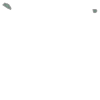

In [17]:
kigali_industrial.unary_union

In [8]:
kigali_roads.head()

,element_type,osmid,highway,traffic_signals,geometry,sidewalk:right,surface,name,bus,public_transport,...,footway,area,tunnel,maxspeed:forward,description,noname,sidewalk:both,junction:ref,covered,destination:lang
0,node,279245303,traffic_signals,signal,POINT (30.05672 -1.93932),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,317706734,bus_stop,NaN,POINT (30.06087 -1.94326),NaN,NaN,NaN,yes,platform,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node,1223047214,traffic_signals,NaN,POINT (30.04363 -1.94006),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node,1224717363,crossing,NaN,POINT (30.06369 -1.96130),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node,3205794939,bus_stop,NaN,POINT (30.06493 -1.94539),NaN,NaN,Péage,yes,platform,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Extract road types
#this should actually create two columns: residential, and through_road
#both binary: 1 if point is on a residential road, 0 if not
#likewise for through_road
is_res_road = kigali_roads[lambda gdf: gdf['highway'].isin(['residential', 'living_street'])]
is_through_road = kigali_roads[lambda gdf: gdf['highway'].isin(['primary', 'primary_link','trunk'
    , 'trunk_link', 'secondary','secondary_link', 'tertiary', 'tertiary_link', 'unclassified'])]

In [12]:
is_through_road["highway"].unique()

array(['secondary', 'trunk', 'unclassified', 'tertiary', 'primary',
       'trunk_link', 'secondary_link', 'primary_link', 'tertiary_link'],
      dtype=object)

In [9]:
data_osm = get_location_characteristics(data_aggregated)

C:\Users\nial\AppData\Local\Temp\ipykernel_24220\2772699581.py:40: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  major_roads['buffer'] = major_roads.geometry.buffer(5)  # 5 meter buffer
C:\Users\nial\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\nial\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\geopandas\base.py:31: UserWarning: The indices of

In [10]:
data_osm.to_csv(r"C:\Users\nial\OneDrive\Documents\ETH-Zürich-DESKTOP-9E8KBS8\AQ Data Collection\data_osm.csv")

In [11]:
data_osm = pd.read_csv(r"C:\Users\nial\OneDrive\Documents\ETH-Zürich-DESKTOP-9E8KBS8\AQ Data Collection\data_osm.csv")

In [15]:
data_osm["major.road"].sum()

0

In [21]:
kig_geom = ox.geometries.geometries_from_place("Kigali", tags={'highway':True})